# Expectation Maximization

This notebook provides educational implementations of two important algorithms in machine learning:

1. **Expectation Maximization (EM) Algorithm**
   - Implementation with Gaussian Mixture Models
   - Visualization of clustering process
   - Step-by-step explanation of E-step and M-step

In [5]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from typing import List, Tuple, Dict
import random
from IPython.display import clear_output

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Expectation Maximization Algorithm

We'll implement EM for Gaussian Mixture Models (GMM). The algorithm has two main steps:

1. **E-step (Expectation)**:
   - Calculate the probability of each data point belonging to each Gaussian component
   - Using current parameter estimates

2. **M-step (Maximization)**:
   - Update the parameters (means, covariances, weights) using the probabilities
   - Maximize the expected log-likelihood

Let's implement these steps for a 2D dataset.

In [2]:
class GaussianMixture:
    def __init__(self, n_components: int = 2):
        """Initialize GMM with n_components Gaussian components."""
        self.n_components = n_components
        self.means = None
        self.covs = None
        self.weights = None
        
    def initialize_parameters(self, X: np.ndarray):
        """Initialize means, covariances, and weights randomly."""
        n_samples, n_features = X.shape
        
        # Initialize means randomly from data points
        idx = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[idx]
        
        # Initialize covariances as identity matrices
        self.covs = [np.eye(n_features) for _ in range(self.n_components)]
        
        # Initialize weights uniformly
        self.weights = np.ones(self.n_components) / self.n_components
        
    def e_step(self, X: np.ndarray) -> np.ndarray:
        """Expectation step: compute responsibilities."""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        # Compute probability for each data point under each Gaussian
        for k in range(self.n_components):
            gaussian = multivariate_normal(self.means[k], self.covs[k])
            responsibilities[:, k] = self.weights[k] * gaussian.pdf(X)
            
        # Normalize responsibilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities
    
    def m_step(self, X: np.ndarray, responsibilities: np.ndarray):
        """Maximization step: update parameters."""
        n_samples = X.shape[0]
        
        # Update weights
        Nk = responsibilities.sum(axis=0)
        self.weights = Nk / n_samples
        
        # Update means
        self.means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
        
        # Update covariances
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covs[k] = np.dot(responsibilities[:, k] * diff.T, diff) / Nk[k]
            
            # Add small value to diagonal for numerical stability
            self.covs[k] += 1e-6 * np.eye(X.shape[1])
    
    def fit(self, X: np.ndarray, n_iterations: int = 20) -> List[float]:
        """Fit the GMM to data."""
        self.initialize_parameters(X)
        log_likelihoods = []
        
        for _ in range(n_iterations):
            # E-step
            responsibilities = self.e_step(X)
            
            # M-step
            self.m_step(X, responsibilities)
            
            # Compute log-likelihood
            ll = self.compute_log_likelihood(X)
            log_likelihoods.append(ll)
        
        return log_likelihoods
    
    def compute_log_likelihood(self, X: np.ndarray) -> float:
        """Compute log-likelihood of the data."""
        n_samples = X.shape[0]
        likelihood = np.zeros(n_samples)
        
        for k in range(self.n_components):
            gaussian = multivariate_normal(self.means[k], self.covs[k])
            likelihood += self.weights[k] * gaussian.pdf(X)
            
        return np.sum(np.log(likelihood))

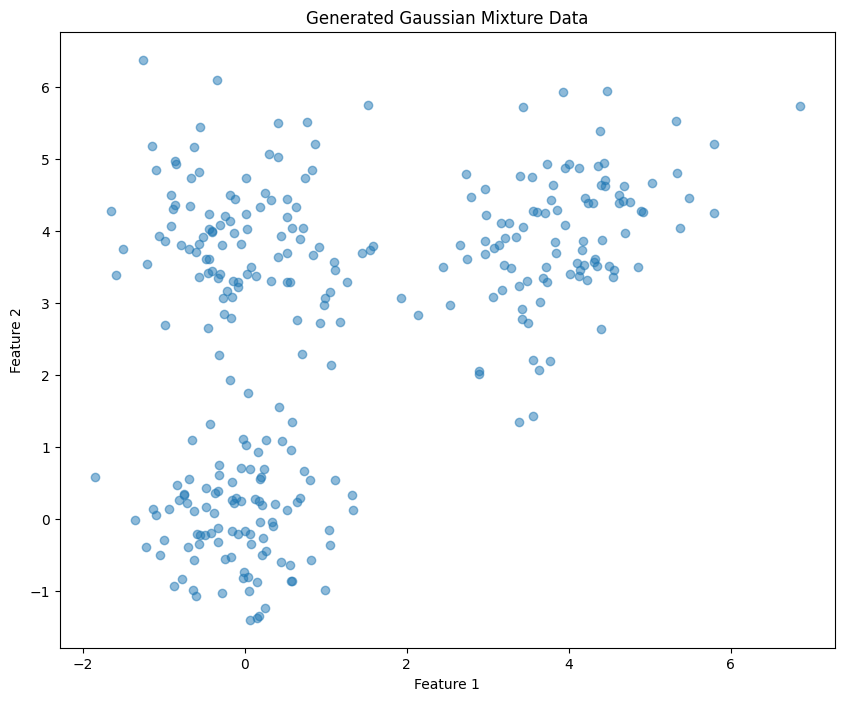

In [3]:
# Create synthetic dataset
def generate_gaussian_data(n_samples: int = 300) -> np.ndarray:
    """Generate synthetic data from three Gaussians."""
    n_samples_per_cluster = n_samples // 3
    
    # Generate three clusters
    cluster1 = np.random.multivariate_normal(
        mean=[0, 0],
        cov=[[0.5, 0], [0, 0.5]],
        size=n_samples_per_cluster
    )
    
    cluster2 = np.random.multivariate_normal(
        mean=[4, 4],
        cov=[[0.8, 0.2], [0.2, 0.8]],
        size=n_samples_per_cluster
    )
    
    cluster3 = np.random.multivariate_normal(
        mean=[0, 4],
        cov=[[0.6, -0.1], [-0.1, 0.6]],
        size=n_samples_per_cluster
    )
    
    # Combine clusters
    X = np.vstack([cluster1, cluster2, cluster3])
    np.random.shuffle(X)
    return X

# Generate data
X = generate_gaussian_data(300)

# Plot the data
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.title("Generated Gaussian Mixture Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

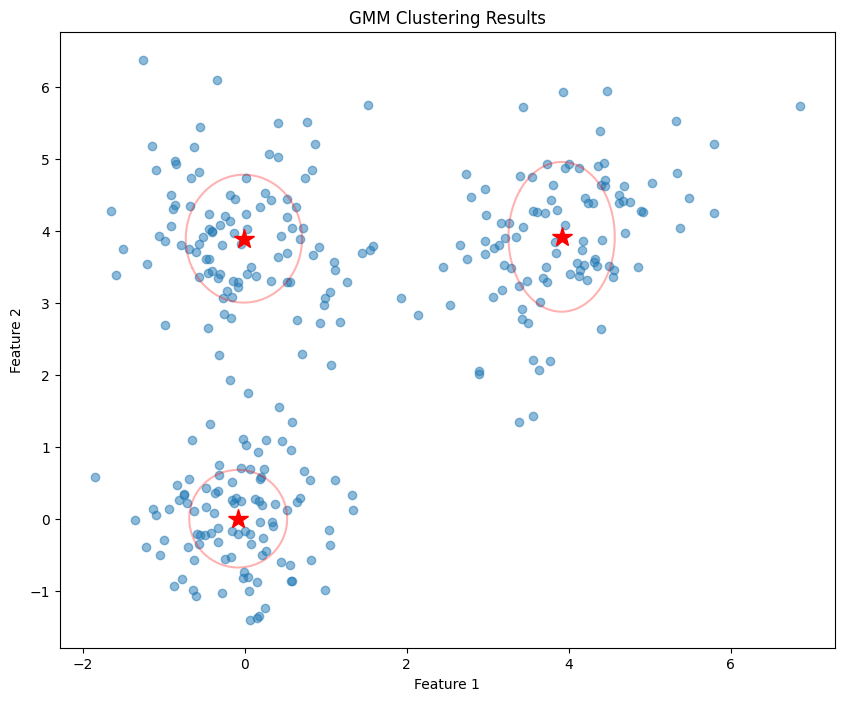

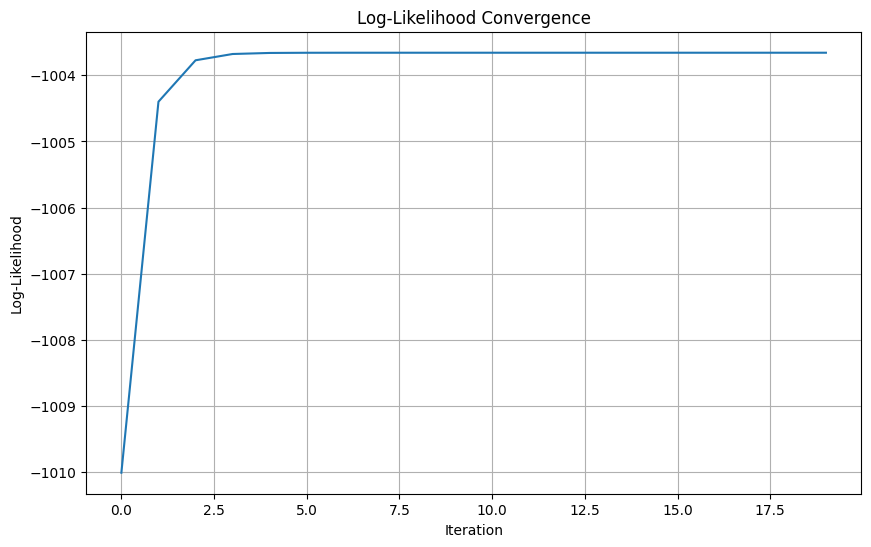

In [4]:
# Fit GMM and visualize results
def plot_gmm_results(X: np.ndarray, gmm: GaussianMixture, title: str):
    """Plot data points and Gaussian components."""
    plt.figure(figsize=(10, 8))
    
    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
    
    # Plot Gaussian components
    for k in range(gmm.n_components):
        mean = gmm.means[k]
        cov = gmm.covs[k]
        
        # Generate points for ellipse
        eigenvals, eigenvecs = np.linalg.eigh(cov)
        theta = np.linspace(0, 2*np.pi, 100)
        ellipse = np.c_[np.cos(theta), np.sin(theta)]
        
        # Scale and rotate ellipse
        transform = np.sqrt(eigenvals)[:, np.newaxis] * eigenvecs
        ellipse = mean + ellipse @ transform.T
        
        plt.plot(ellipse[:, 0], ellipse[:, 1], 'r-', alpha=0.3)
        plt.plot(mean[0], mean[1], 'r*', markersize=15)
    
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Initialize and fit GMM
gmm = GaussianMixture(n_components=3)
log_likelihoods = gmm.fit(X)

# Plot results
plot_gmm_results(X, gmm, "GMM Clustering Results")

# Plot log-likelihood convergence
plt.figure(figsize=(10, 6))
plt.plot(log_likelihoods)
plt.title("Log-Likelihood Convergence")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.show()

## Understanding the Results

### Expectation Maximization (GMM)
1. The algorithm successfully identified the three Gaussian components in our synthetic data
2. The ellipses show the covariance structure of each component
3. The log-likelihood plot shows convergence of the algorithm